# Answering Business Questions using SQL

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create a function that takes a SQL query as an argument and returns a
# pandas dataframe of that query
def run_query(q):
    with sqlite3.connect("chinook.db") as conn:
        return pd.read_sql(q, conn)
    
# Create a function that takes a SQL command as an argument and executes it
# usig sqlite module
def run_command(c):
    with sqlite3.connect("chinook.db") as conn:
        conn.isolation_level = None
        conn.execute(c)
        
# Create a function that calls the run_query() function o return a list of all 
# tables and views in the database
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the **first three albums** that will be added to the store, from a **list of four**. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|Artist Name                      |Genre            |
|---------------------------------|-----------------|
|Regal                            |Hip_Hop          |
|Red Tone                         |Punk             |
|Meteor and the Girls             |Pop              |
|Slim Jim Bites                   |Blues            |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [3]:
best_sales_usa = '''
WITH
    tracks_and_genres AS
    (
     SELECT 
         g.name genre_name,
         t.track_id
     FROM genre g
     LEFT JOIN track t ON t.genre_id = g.genre_id
    ),
    tracks_and_genres_usa AS
    (
     SELECT
         tag.genre_name genre_name,
         tag.track_id track,
         i.billing_country country
     FROM tracks_and_genres tag
     INNER JOIN invoice_line il ON il.track_id = tag.track_id
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     WHERE country = 'USA'
    )
SELECT 
    genre_name genre,
    COUNT(track) 'number of tracks sold',
    CAST(COUNT(track) as float)/CAST(
        (SELECT COUNT(*) FROM tracks_and_genres_usa)
        as float) 'percentage of tracks sold'
FROM tracks_and_genres_usa tagu
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''
sales_usa = run_query(best_sales_usa)
sales_usa

,genre,number of tracks sold,percentage of tracks sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


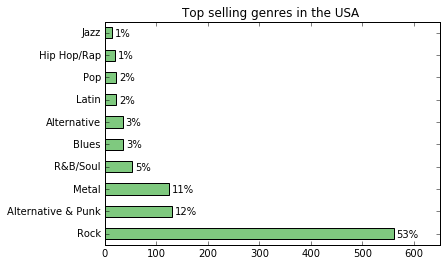

In [4]:
from matplotlib import cm
sales_usa.set_index('genre', drop=True, inplace=True)
sales_usa['number of tracks sold'].plot.barh(
    title = "Top selling genres in the USA ",
    xlim = (0,650),
    colormap = plt.cm.Accent
    )

plt.ylabel('')

for i, label in enumerate(list(sales_usa.index)):
    score = sales_usa.loc[label, "number of tracks sold"]
    label = (sales_usa.loc[label, "percentage of tracks sold"]*100).astype(int).astype(str) + '%'
    plt.annotate(str(label), (score+5, i-0.15))

plt.show()

According to the chart, *Rock* is the best genre sold in the USA with 561 tracks sold (more than 53% of the national sales). *Punk* holds the second position with 130 tracks sold (12,3%). *Blues*, *Pop* and *Hip-Hop* arrive respectively at 4th, 7th and 8th range of the chart.

In conclusion, the 3 best albums to add in the store are **Red Tone** (punk), **Slim Jim Bites** (blues) and **Meteor and the Girls** (pop).

## Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make the purchase. We have asked to analyze **the purchases of customers belonging to each employee** to see if any sales support agent is performing either better or worse than the others.

In [5]:
employee_performance = '''
WITH  
    purchase_per_customer AS
    (
     SELECT 
         c.customer_id,
         c.support_rep_id,
         SUM(i.total) total_purchased
     FROM customer c
     INNER JOIN invoice i ON i.customer_id = c.customer_id
     GROUP BY 1, 2
    )
SELECT
    e.first_name || " " || e.last_name employee_name,
    e.hire_date hire_date,
    e.country country,
    SUM(ppc.total_purchased) total_sales
FROM employee e
INNER JOIN purchase_per_customer ppc ON ppc.support_rep_id = e.employee_id
GROUP BY 1
ORDER BY 1
LIMIT 20;
'''

run_query(employee_performance)

,employee_name,hire_date,country,total_sales
0,Jane Peacock,2017-04-01 00:00:00,Canada,1731.51
1,Margaret Park,2017-05-03 00:00:00,Canada,1584.00
2,Steve Johnson,2017-10-17 00:00:00,Canada,1393.92


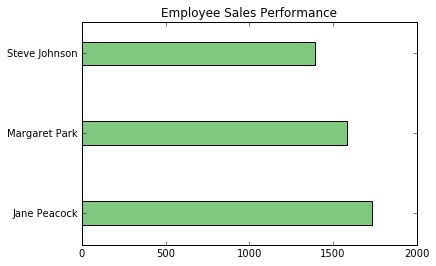

In [6]:
e_p = run_query(employee_performance)
e_p.set_index("employee_name", inplace=True)

e_p['total_sales'].plot.barh(
    title = "Employee Sales Performance", 
    xlim=(0,2000), 
    width=0.3,
    colormap = plt.cm.Accent)
plt.yticks(rotation=0)
plt.ylabel("")
plt.show()

Jane Peacock has the biggest sales performance, Margaret Park arrives at second position and Steve Johnson third one. If we look at the time when they was hired, Jane Peacook was part of the company in April, Margaret Park in May and Steve Johnson in October. So the sales performance go normaly with the hiring time.

## Analyzing Sales by country

In [7]:
sales_by_country = '''
WITH
    country_or_other AS
    (
     SELECT 
         CASE
             WHEN (
                   SELECT COUNT(*)
                   FROM customer
                   WHERE country = c.country
                   ) = 1 THEN 'Other'
             ELSE c.country
         END AS country,
         c.customer_id,
         il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )
    
SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (SELECT
        country,
        COUNT(DISTINCT customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price)/COUNT(DISTINCT customer_id) customer_lifetime_value,
        SUM(unit_price)/COUNT(DISTINCT invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
     FROM country_or_other
     GROUP BY 1
     ORDER BY 6 ASC, 3 DESC)
'''
run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


## Visualizing Sales by Country

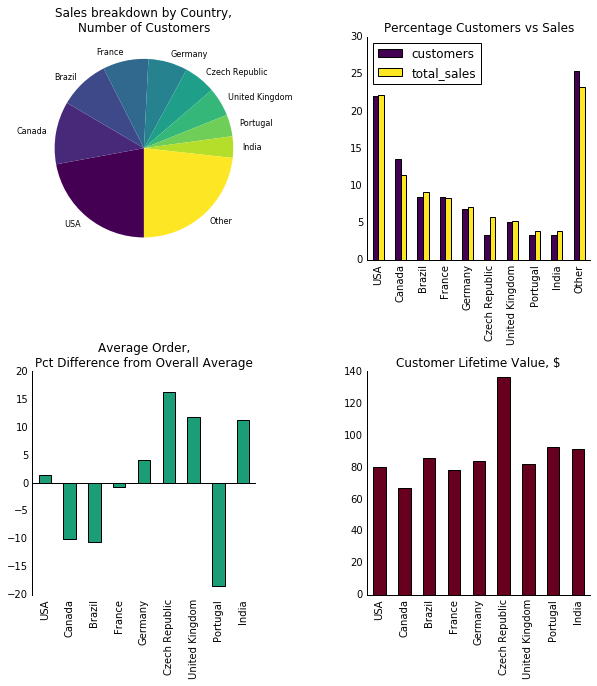

In [8]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", inplace=True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.5)

# ax1 - top left
sales_distribution = country_metrics["total_sales"].copy().rename('')
sales_distribution.plot.pie(
    ax = ax1,
    startangle = -90,
    counterclock = False,
    title = "Sales breakdown by Country,\nNumber of Customers",
    colormap = plt.cm.viridis,
    fontsize = 8,
    wedgeprops = {'linewidth':0}
)

# ax2 - top right
cvs_cols = ['customers', 'total_sales']
cust_vs_sales = country_metrics[cvs_cols].copy()
cust_vs_sales.index.name = ""

for c in cvs_cols:
    cust_vs_sales[c] /= cust_vs_sales[c].sum() / 100
    
cust_vs_sales.plot.bar(
    ax = ax2,
    colormap = plt.cm.viridis,
    title = "Percentage Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# ax3 - bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
diff_from_overall_avg = avg_order * 100 / avg_order.mean() - 100
diff_from_overall_avg.drop('Other', inplace=True)

diff_from_overall_avg.plot.bar(
    ax = ax3,
    colormap = plt.cm.Dark2,
    title = "Average Order,\nPct Difference from Overall Average",
)
ax3.tick_params(top="off", bottom="off", right="off", left="off")
ax3.axhline(0, color="black")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# ax4 - bottom right
clv = country_metrics['customer_lifetime_value'].copy()
clv.index.name = ''
clv.drop('Other', inplace=True)

clv.plot.bar(
    ax = ax4,
    colormap = plt.cm.RdBu,
    title = 'Customer Lifetime Value, $'
)
ax4.tick_params(top="off", right="off", bottom="off", left="off")
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.show()

## Albums and Individual Tracks

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so the management can use this data to understand the effect this decision might have on overall revenue.

In this instance, we have two edge cases to consider:
- Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
- Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue, we can safely **ignore albums consisting only a few tracks**. The company has previously done analysis to confirm that the second case does not happen often, so we can **ignore this case** also.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album.

In [16]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
          il.invoice_id invoice_id,
          MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    ),
    albums_and_tracks AS
    (
     SELECT
         ift.*,
         CASE
             WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (select t2.album_id from track t2
                                      where t2.track_id = ift.first_track_id) 
                                 
                  EXCEPT 
                 
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ift.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ift.invoice_id
                  
                  EXCEPT
                  
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (select t2.album_id from track t2
                                      where t2.track_id = ift.first_track_id)
                 ) IS NULL
             THEN "yes"
             ELSE "no"
        END AS album_purchase
     FROM invoice_first_track ift
    )

SELECT 
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) as float)/CAST((select COUNT(*) from invoice) as float)pct_of_invoices
FROM albums_and_tracks
GROUP BY 1;

'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,pct_of_invoices
0,no,500,0.814332
1,yes,114,0.185668


Based on the data, the purchased albums account only for 19% of total purchase. We would recommand that the Chinook store shouldn't cootinue to buy full albums from record companies, but focusing on single track instead. 